<a href="https://colab.research.google.com/github/HollaKaustubh/CoderOne/blob/main/Text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Summarization**

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr
# Install required libraries
!pip install transformers datasets torch
from datasets import load_dataset

# Load the CNN/Daily Mail dataset
dataset = load_dataset('cnn_dailymail', '3.0.0')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the T5 model and tokenizer
model_name = "t5-small"  # You can change this to t5-base, t5-large, etc.
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(example):
    # Concatenate article with prefix for T5
    inputs = [f"summarize: {item}" for item in example['article']]
    # Tokenize inputs and summaries
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length", return_tensors="pt")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example['highlights'], max_length=150, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the tokenization function to the dataset
tokenized_dataset = dataset.map(tokenize_data, batched=True)


Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader

# Define a DataLoader for the test set
batch_size = 8  # You can adjust this
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=batch_size)


In [ ]:
import torch

model.eval()  # Set the model to evaluation mode

# Function to generate summaries
def generate_summary(batch):
    inputs = torch.stack(batch['input_ids']).to(device)
    attention_mask = torch.stack(batch['attention_mask']).to(device)
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=150)
    return [tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True) for output in outputs]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Generate and print summaries for a few examples
for batch in test_dataloader:
    summaries = generate_summary(batch)
    for summary in summaries:
        print(summary)
   # Remove this line if you want to generate summaries for the entire dataset


Streaming output truncated to the last 5000 lines.
Family Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo Fo
Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circle Circ

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Compute ROUGE scores
for batch in test_dataloader:
    summaries = generate_summary(batch)
    for ref, pred in zip(batch['labels'], summaries):
        ref_text = tokenizer.decode(ref, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        scores = scorer.score(ref_text, pred)
        print(scores)
    break  # Remove this line if you want to compute scores for the entire dataset


AttributeError: 'list' object has no attribute 'to'

In [ ]:
!pip install transformers datasets torch rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=143816ca4e7206ebc322f226065134e98200d5d9f0bb9b2418edde95dde6fe58
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})

In [ ]:
dataset['train'][1]['article'][:350]

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial'

In [ ]:
dataset['train'][1]['highlights'][:350]

'Mentally ill inmates in Miami are housed on the "forgotten floor"\nJudge Steven Leifman says most are there as a result of "avoidable felonies"\nWhile CNN tours facility, patient shouts: "I am the son of the president"\nLeifman says the system is unjust and he\'s fighting for change .'

In [ ]:
from transformers import pipeline
pipe = pipeline("text-generation", model="gpt2-medium")

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
dataset['train'][1]['article'][:2000]
input_text = dataset['train'][1]['article'][:2000]
query = input_text + "\nTL;DR:\n"
pipe_out = pipe(query,max_length=512,clean_up_tokenization_spaces=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
pipe_out[0]['generated_text'][len(query):]

'* A jail where thousands of people with mental illness are placed in solitary confinement for long periods of time without contact with anyone else.\n* People who are on the wrong side of the law -- in prison, jail or on trial. There are no beds, shower - no air circulation. Everyone is confined to a small cell and the rules are as follows: 1. The prisoner cannot'

In [ ]:
summaries = {}
summaries['gpt2-medium-380M']=pipe_out[0]['generated_text'][len(query):]

In [ ]:
# Try out for T5 Transformer

In [ ]:
pipe = pipeline("summarization", model="t5-base")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
pipe_out = pipe(input_text)

In [ ]:
summaries['t5-base-223M']=pipe_out[0]['summary_text']

In [ ]:
pipe = pipeline('summarization', model = 'facebook/bart-large-cnn')
pipe_out = pipe(input_text)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
summaries['bart-large-cnn-400M']=pipe_out[0]['summary_text']

In [ ]:
pipe = pipeline('summarization', model = 'google/pegasus-cnn_dailymail')

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
pipe_out = pipe(input_text)

In [ ]:
summaries['pegasus-cnn-568M']=pipe_out[0]['summary_text']

In [ ]:
for model in summaries :
  print(model.upper())
  print(summaries[model][:500])
  print("")


GPT2-MEDIUM-380M
* A jail where thousands of people with mental illness are placed in solitary confinement for long periods of time without contact with anyone else.
* People who are on the wrong side of the law -- in prison, jail or on trial. There are no beds, shower - no air circulation. Everyone is confined to a small cell and the rules are as follows: 1. The prisoner cannot

T5-BASE-223M
mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida . inmates with the most severe mental illnesses are incarcerated until they're ready to appear . a judge says the arrests often result from confrontations with police . mentally ill people often won't do what police say, judge says .

BART-LARGE-CNN-400M
Mentally ill inmates are housed on the "forgotten floor" of Miami-Dade jail. Most often, they face drug charges or charges of assaulting an officer. Judge Steven Leifman says the arrests often result from confrontations with police. He says about one-t

In [ ]:
from datasets import load_dataset
from transformers import pipeline
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
samsum = load_dataset('samsum')
samsum

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] Y


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['dialogue'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

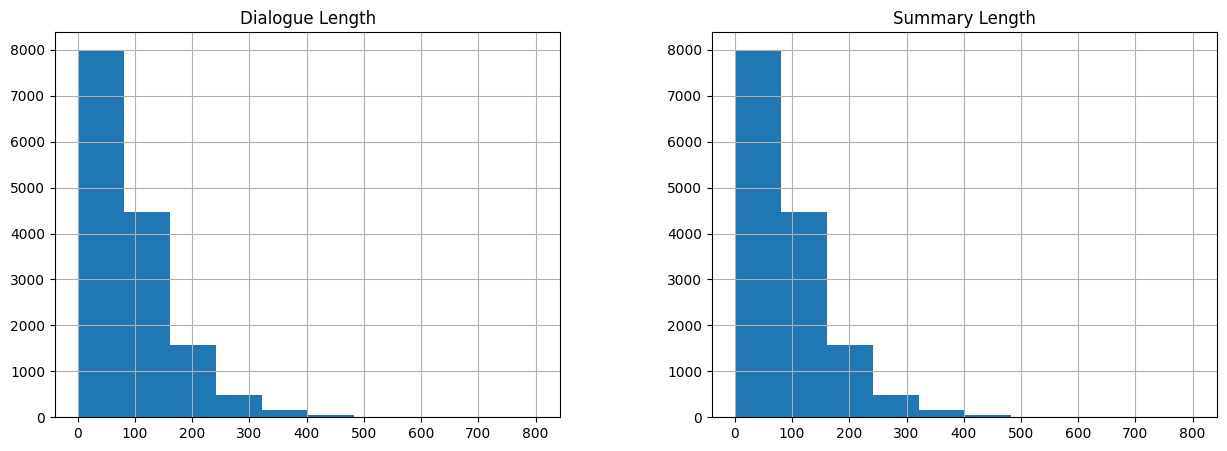

In [ ]:
import pandas as pd
data = pd.DataFrame([dialogue_len,summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [ ]:
# lets build data collator
def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target = batch['summary'],
max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
              'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
samsum_pt = samsum.map(get_feature, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
samsum_pt['train']

Dataset({
    features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 14732
})

In [ ]:
coloumns = ['input_ids','labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=coloumns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs = 1,
    warmup_steps = 500,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps = 500,
    save_steps = 1e6,
    gradient_accumulation_steps = 16
)
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator = data_collator,
                  train_dataset=samsum_pt['train'],eval_dataset=samsum_pt['validation'])

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
